Using video_folder: /home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed
Processing directory: 10
Found 101 normal CSV files
Found 58 abnormal CSV files
Processing directory: 11
Found 248 normal CSV files
Found 103 abnormal CSV files
Processing directory: 12
Found 206 normal CSV files
Found 70 abnormal CSV files
Loaded 697 trajectories after filtering.
Feature extraction complete. Sample data:
   track_id  label                                          file_path  \
0         1      0  /home/run/media/localdiskD/Ahmedabad Universit...   
1         2      0  /home/run/media/localdiskD/Ahmedabad Universit...   
2         3      0  /home/run/media/localdiskD/Ahmedabad Universit...   
3         4      0  /home/run/media/localdiskD/Ahmedabad Universit...   
4         5      0  /home/run/media/localdiskD/Ahmedabad Universit...   

   wrong_way_movement  curvature_adherence  speed_accel_violations  \
0                 0.0             0.948121

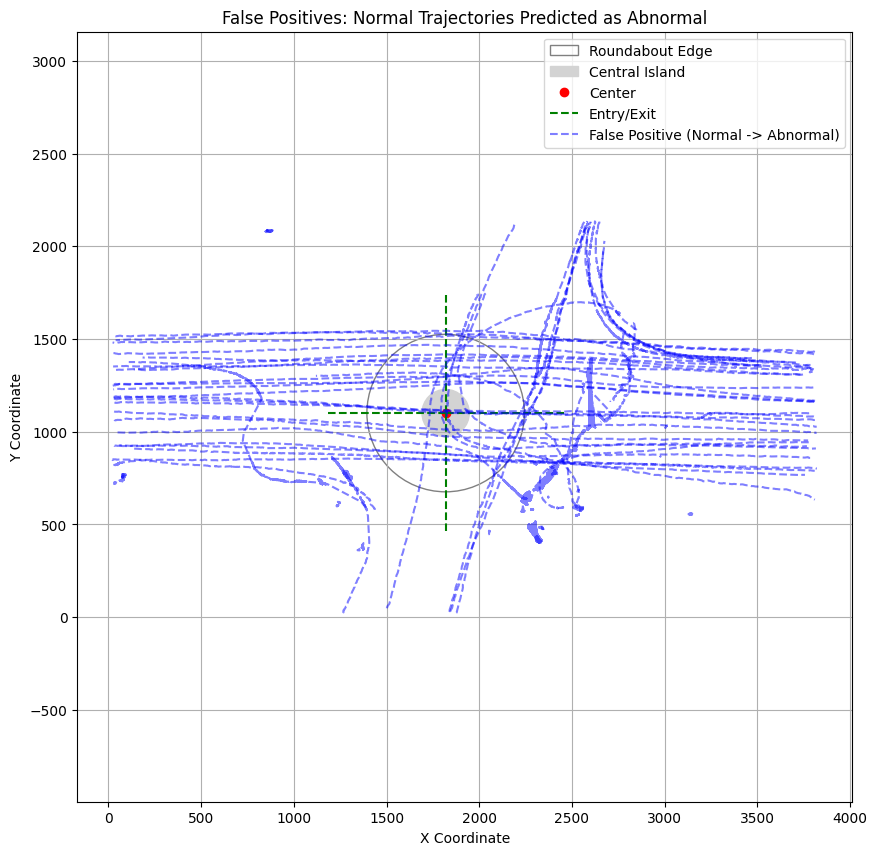

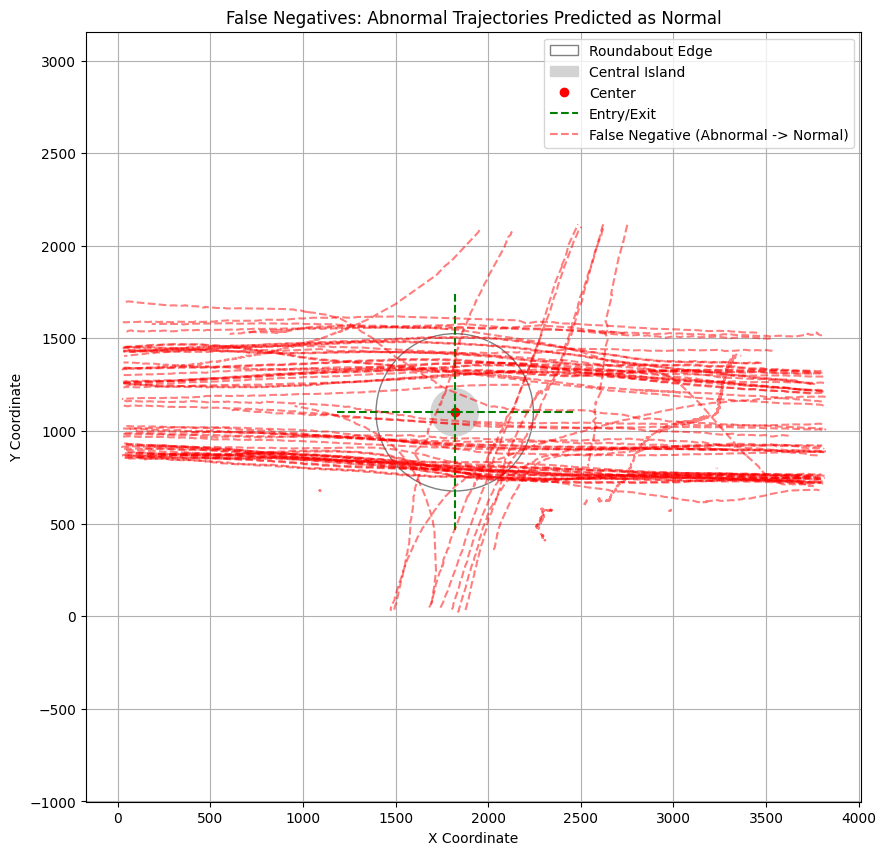

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# --- Data Loading Function ---
def load_trajectories(video_folder: str, min_points: int = 7) -> Tuple[List[pd.DataFrame], List[int], List[str]]:
    trajectories, labels, file_paths = [], [], []
    for root, dirs, _ in os.walk(video_folder):
        if 'normal' in dirs and 'abnormal' in dirs:
            numbered_dir = os.path.basename(root)
            print(f"Processing directory: {numbered_dir}")
            for folder, label in [('normal', 0), ('abnormal', 1)]:
                path = os.path.join(root, folder)
                files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
                print(f"Found {len(files)} {folder} CSV files")
                for file in files:
                    df = pd.read_csv(file)[['frameNo', 'left', 'top', 'w', 'h']].sort_values(by='frameNo')
                    if len(df) >= min_points:
                        trajectories.append(df)
                        labels.append(label)
                        file_paths.append(file)
    return trajectories, labels, file_paths

# --- Helper Functions for Feature Extraction ---
def df_to_points(df: pd.DataFrame) -> List[Tuple[int, float, float]]:
    return [(int(row['frameNo']), row['left'] + row['w'] / 2, row['top'] + row['h'] / 2) for _, row in df.iterrows()]

def derive_roundabout_geometry(normal_trajectories: List[pd.DataFrame]) -> Tuple[float, float, float]:
    all_points = [p for traj_df in normal_trajectories for p in df_to_points(traj_df)]
    if not all_points:
        return 0.0, 0.0, 100.0
    points_array = np.array([(p[1], p[2]) for p in all_points])
    center_x, center_y = np.mean(points_array, axis=0)
    
    # Filter points within a reasonable distance
    distances = np.sqrt((points_array[:, 0] - center_x)**2 + (points_array[:, 1] - center_y)**2)
    filtered_points = points_array[distances <= 700]
    
    # Use DBSCAN on filtered points
    db = DBSCAN(eps=50, min_samples=10).fit(filtered_points)
    labels = db.labels_
    core_points = filtered_points[labels != -1]
    if len(core_points) == 0:
        distances = np.sqrt((points_array[:, 0] - center_x)**2 + (points_array[:, 1] - center_y)**2)
        radius = np.percentile(distances, 75)
    else:
        distances = np.sqrt((core_points[:, 0] - center_x)**2 + (core_points[:, 1] - center_y)**2)
        radius = np.median(distances)
    return center_x, center_y, radius * 0.9

def assign_zone_id(x: float, y: float, center_x: float, center_y: float, radius: float) -> int:
    dx = x - center_x
    dy = y - center_y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx)) % 360
    if distance < radius * 0.3:  # Smaller central island
        return 0
    elif distance < radius:  # Circulating lane
        return 1
    else:  # Entry/Exit lanes
        if 0 <= angle < 90 or 270 <= angle < 360:  # East/North
            return 2
        elif 90 <= angle < 180:  # West
            return 3
        elif 180 <= angle < 270:  # South
            return 4
        else:
            return 5

def get_zone_sequence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> List[int]:
    return [assign_zone_id(p[1], p[2], center_x, center_y, radius) for p in points]

def calculate_forbidden_transitions(zone_seq: List[int]) -> int:
    valid_transitions = {
        (2, 1), (3, 1), (4, 1), (5, 1),  # Entry to circulating
        (1, 2), (1, 3), (1, 4), (1, 5),  # Circulating to exit
        (1, 1),  # Staying in circulating lane
    }
    forbidden_trans = 0
    for i in range(1, len(zone_seq)):
        if (zone_seq[i-1] in [2, 3, 4, 5] and zone_seq[i] in [2, 3, 4, 5] and 
            all(z != 1 for z in zone_seq[max(0, i-5):i+1])):
            forbidden_trans += 1
    return forbidden_trans

def calculate_wrong_way_movement(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float) -> float:
    angles = []
    for i in range(1, len(points)):
        x1, y1 = points[i-1][1] - center_x, points[i-1][2] - center_y
        x2, y2 = points[i][1] - center_x, points[i][2] - center_y
        angle1 = np.arctan2(y1, x1)
        angle2 = np.arctan2(y2, x2)
        angle_diff = (angle2 - angle1) % (2 * np.pi)
        if angle_diff > np.pi:
            angle_diff -= 2 * np.pi
        angles.append(angle_diff)
    wrong_way_score = np.sum(np.array(angles) < 0) / len(angles) if angles else 0.0
    return 1.0 if wrong_way_score > 0.2 else 0.0

def calculate_curvature_adherence(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, fps: float = 1.0) -> float:
    expected_curvatures = []
    actual_curvatures = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        velocity = distance / time if time > 0 else 0.0
        expected_curvature = velocity / (radius * 0.9) if radius > 0 else 0.0
        
        x1, y1 = points[i-1][1] - center_x, points[i-1][2] - center_y
        x2, y2 = points[i][1] - center_x, points[i][2] - center_y
        angle1 = np.arctan2(y1, x1)
        angle2 = np.arctan2(y2, x2)
        angle_diff = abs((angle2 - angle1) % (2 * np.pi))
        if angle_diff > np.pi:
            angle_diff = 2 * np.pi - angle_diff
        actual_curvature = angle_diff / time if time > 0 else 0.0
        
        expected_curvatures.append(expected_curvature)
        actual_curvatures.append(actual_curvature)
    if not expected_curvatures:
        return 0.0
    differences = np.abs(np.array(actual_curvatures) - np.array(expected_curvatures))
    mean_diff = np.mean(differences)
    adherence = 1 / (1 + mean_diff * 2)
    return max(0.0, min(1.0, adherence))

def calculate_circulation_completion(points: List[Tuple[int, float, float]], center_x: float, center_y: float) -> float:
    angles = []
    for p in points:
        dx = p[1] - center_x
        dy = p[2] - center_y
        angle = np.degrees(np.arctan2(dy, dx)) % 360
        angles.append(angle)
    if len(angles) < 2:
        return 0.0
    angle_change = max(angles) - min(angles) if max(angles) > min(angles) else 360 + max(angles) - min(angles)
    return 1.0 if angle_change > 300 else 0.0

def calculate_speed_and_acceleration_violations(points: List[Tuple[int, float, float]], normal_speed_min: float, normal_speed_max: float, normal_accel_max: float, fps: float = 1.0) -> float:
    speeds = []
    accels = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    for i in range(1, len(speeds)):
        time = (points[i+1][0] - points[i][0]) / fps
        accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
        accels.append(abs(accel))
    speed_violations = sum(1 for s in speeds if s < normal_speed_min or s > normal_speed_max)
    accel_violations = sum(1 for a in accels if a > normal_accel_max)
    total_violations = speed_violations + accel_violations
    return total_violations / len(points) if points else 0.0

def calculate_sudden_stops(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, fps: float = 1.0) -> float:
    speeds = []
    for i in range(1, len(points)):
        dx = points[i][1] - points[i-1][1]
        dy = points[i][2] - points[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = (points[i][0] - points[i-1][0]) / fps
        speed = distance / time if time > 0 else 0.0
        speeds.append(speed)
    stop_count = 0
    for i, point in enumerate(points):
        distance = np.sqrt((point[1] - center_x)**2 + (point[2] - center_y)**2)
        if distance < radius and i < len(speeds) and speeds[i] < 1e-3:
            stop_count += 1
    return stop_count / len(points) if points else 0.0

def calculate_roundabout_deviation(points: List[Tuple[int, float, float]], center_x: float, center_y: float, radius: float, normal_avg_dist: float, normal_dist_std: float) -> float:
    distances = np.sqrt((np.array([p[1] for p in points]) - center_x)**2 + (np.array([p[2] for p in points]) - center_y)**2)
    mean_distance = np.mean(distances)
    distance_std = np.std(distances) if len(distances) > 1 else 0.0
    deviation_score = 0.0
    if mean_distance > radius:
        deviation_score += (mean_distance - radius) / (normal_avg_dist + 1e-6)
    if distance_std > normal_dist_std:
        deviation_score += (distance_std - normal_dist_std) / (normal_dist_std + 1e-6)
    return deviation_score * 0.5  # Reduce sensitivity

def calculate_path_efficiency(points: List[Tuple[int, float, float]]) -> float:
    total_distance = np.sum(np.sqrt(np.diff([p[1] for p in points])**2 + np.diff([p[2] for p in points])**2))
    start_end_distance = np.sqrt((points[-1][1] - points[0][1])**2 + (points[-1][2] - points[0][2])**2)
    return start_end_distance / total_distance if total_distance > 0 else 1.0

# --- Precompute Averages for Thresholds ---
def compute_averages(trajectories: List[pd.DataFrame], labels: List[int], fps: float = 1.0) -> Tuple[float, float, float, float, float]:
    normal_speeds = []
    normal_accels = []
    normal_dist = []
    normal_dist_stds = []
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    for traj_df in normal_trajectories:
        points = df_to_points(traj_df)
        distances = np.sqrt((np.array([p[1] for p in points]) - center_x)**2 + (np.array([p[2] for p in points]) - center_y)**2)
        avg_dist = np.mean(distances) if len(distances) > 0 else 0.0
        dist_std = np.std(distances) if len(distances) > 1 else 0.0
        normal_dist.append(avg_dist)
        normal_dist_stds.append(dist_std)
        speeds = []
        accels = []
        for i in range(1, len(points)):
            dx = points[i][1] - points[i-1][1]
            dy = points[i][2] - points[i-1][2]
            distance = np.sqrt(dx**2 + dy**2)
            time = (points[i][0] - points[i-1][0]) / fps
            speed = distance / time if time > 0 else 0.0
            speeds.append(speed)
        for i in range(1, len(speeds)):
            time = (points[i+1][0] - points[i][0]) / fps
            accel = (speeds[i] - speeds[i-1]) / time if time > 0 else 0.0
            accels.append(abs(accel))
        normal_speeds.extend(speeds)
        normal_accels.extend(accels)
    normal_speed_min = np.percentile(normal_speeds, 5) if normal_speeds else 0.0
    normal_speed_max = np.percentile(normal_speeds, 95) if normal_speeds else 10.0
    normal_accel_max = np.percentile(normal_accels, 95) if normal_accels else 1.0
    normal_avg_dist = np.mean(normal_dist) if normal_dist else radius
    normal_dist_std = np.mean(normal_dist_stds) if normal_dist_stds else 0.0
    return normal_speed_min, normal_speed_max, normal_accel_max, normal_avg_dist, normal_dist_std

# --- Feature Extraction ---
def extract_features(trajectories: List[pd.DataFrame], labels: List[int], file_paths: List[str], fps: float = 1.0) -> pd.DataFrame:
    normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
    center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
    normal_speed_min, normal_speed_max, normal_accel_max, normal_avg_dist, normal_dist_std = compute_averages(trajectories, labels, fps)

    results = []
    for idx, (traj_df, label, file_path) in enumerate(zip(trajectories, labels, file_paths)):
        points = df_to_points(traj_df)
        zone_seq = get_zone_sequence(points, center_x, center_y, radius)

        features = {
            'track_id': idx + 1,
            'label': label,
            'file_path': file_path,
            'wrong_way_movement': calculate_wrong_way_movement(points, center_x, center_y, radius),
            'curvature_adherence': calculate_curvature_adherence(points, center_x, center_y, radius, fps),
            'speed_accel_violations': calculate_speed_and_acceleration_violations(points, normal_speed_min, normal_speed_max, normal_accel_max, fps),
            'sudden_stops': calculate_sudden_stops(points, center_x, center_y, radius, fps),
            'roundabout_deviation': calculate_roundabout_deviation(points, center_x, center_y, radius, normal_avg_dist, normal_dist_std),
            'path_efficiency': calculate_path_efficiency(points),
            'forbidden_transitions': calculate_forbidden_transitions(zone_seq),
            'circulation_completion': calculate_circulation_completion(points, center_x, center_y),
        }
        results.append(features)

    return pd.DataFrame(results)

# --- Data Preprocessing and Cleaning ---
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1 or df[col].sum() == 0]
    df = df.drop(columns=constant_cols)
    return df

# --- Ensemble Prediction Function ---
def ensemble_predict(db_labels: np.ndarray, rf_pred: np.ndarray, rf_prob: np.ndarray, threshold: float = 0.40) -> np.ndarray:
    rf_adjusted = (rf_prob[:, 1] >= threshold).astype(int)
    combined = np.vstack((db_labels, rf_adjusted))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined)

# --- Plotting Function ---
def plot_misclassified_trajectories(misclassified_paths: List[Tuple[str, int, int]], video_folder: str, center_x: float, center_y: float, radius: float):
    false_positives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 0 and pl == 1]
    false_negatives = [(fp, tl, pl) for fp, tl, pl in misclassified_paths if tl == 1 and pl == 0]

    plt.figure(figsize=(10, 10))
    circle = plt.Circle((center_x, center_y), radius, color='gray', fill=False, label='Roundabout Edge')
    island = plt.Circle((center_x, center_y), radius * 0.3, color='lightgray', fill=True, label='Central Island')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(island)
    plt.plot(center_x, center_y, 'ro', label='Center')
    
    for angle in [90, 180, 270, 0]:
        rad = np.radians(angle)
        x = center_x + radius * 1.5 * np.cos(rad)
        y = center_y + radius * 1.5 * np.sin(rad)
        plt.plot([center_x, x], [center_y, y], 'g--', label='Entry/Exit' if angle == 90 else "")
    
    for file_path, true_label, pred_label in false_positives:
        df = pd.read_csv(file_path)
        points = df_to_points(df)
        x_coords = [p[1] for p in points]
        y_coords = [p[2] for p in points]
        plt.plot(x_coords, y_coords, 'b--', alpha=0.5, label='False Positive (Normal -> Abnormal)' if false_positives.index((file_path, true_label, pred_label)) == 0 else "")
    
    plt.title("False Positives: Normal Trajectories Predicted as Abnormal")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(10, 10))
    circle = plt.Circle((center_x, center_y), radius, color='gray', fill=False, label='Roundabout Edge')
    island = plt.Circle((center_x, center_y), radius * 0.3, color='lightgray', fill=True, label='Central Island')
    plt.gca().add_patch(circle)
    plt.gca().add_patch(island)
    plt.plot(center_x, center_y, 'ro', label='Center')
    
    for angle in [90, 180, 270, 0]:
        rad = np.radians(angle)
        x = center_x + radius * 1.5 * np.cos(rad)
        y = center_y + radius * 1.5 * np.sin(rad)
        plt.plot([center_x, x], [center_y, y], 'g--', label='Entry/Exit' if angle == 90 else "")
    
    for file_path, true_label, pred_label in false_negatives:
        df = pd.read_csv(file_path)
        points = df_to_points(df)
        x_coords = [p[1] for p in points]
        y_coords = [p[2] for p in points]
        plt.plot(x_coords, y_coords, 'r--', alpha=0.5, label='False Negative (Abnormal -> Normal)' if false_negatives.index((file_path, true_label, pred_label)) == 0 else "")
    
    plt.title("False Negatives: Abnormal Trajectories Predicted as Normal")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    video_folder = "/home/run/media/localdiskD/Ahmedabad University/6th SEM/ML/ML_2025_4_Cluster_555/dataset(Copy)/processed"
    print(f"Using video_folder: {video_folder}")

    trajectories, labels, file_paths = load_trajectories(video_folder, min_points=7)
    print(f"Loaded {len(trajectories)} trajectories after filtering.")

    if len(trajectories) == 0:
        print("No trajectories loaded. Check directory structure.")
    else:
        fps = 1.0
        features_df = extract_features(trajectories, labels, file_paths, fps)
        print("Feature extraction complete. Sample data:")
        print(features_df.head())

        cleaned_df = clean_dataframe(features_df)

        numeric_features = [
            'wrong_way_movement', 'curvature_adherence', 'speed_accel_violations',
            'sudden_stops', 'roundabout_deviation', 'path_efficiency',
            'forbidden_transitions', 'circulation_completion'
        ]
        X = cleaned_df[numeric_features]
        y = np.array(cleaned_df['label'])
        file_paths_array = cleaned_df['file_path'].values
        print(f"Prepared {len(X)} samples with {len(numeric_features)} features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = []
        all_y_true = []
        all_y_pred = []
        all_file_paths = []
        misclassified_paths = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            file_paths_test = file_paths_array[test_idx]

            db = DBSCAN(eps=0.4, min_samples=5).fit(X_train)
            db_labels_train = np.array([1 if label == -1 else 0 for label in db.labels_])
            db_labels_test = np.array([1 if label == -1 else 0 for label in DBSCAN(eps=0.4, min_samples=5).fit_predict(X_test)])

            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 2}
            )
            rf_clf.fit(X_train, y_train)
            rf_pred = rf_clf.predict(X_test)
            rf_prob = rf_clf.predict_proba(X_test)

            y_pred_ensemble = ensemble_predict(db_labels_test, rf_pred, rf_prob, threshold=0.40)

            accuracies.append(accuracy_score(y_test, y_pred_ensemble))
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred_ensemble)
            all_file_paths.extend(file_paths_test)

            misclassified_indices = np.where(y_test != y_pred_ensemble)[0]
            for idx in misclassified_indices:
                true_label = y_test[idx]
                pred_label = y_pred_ensemble[idx]
                misclassified_paths.append((file_paths_test[idx], true_label, pred_label))

        print("\nEnsemble Classification Results (DBSCAN + RandomForest, 5-fold CV):")
        print(classification_report(all_y_true, all_y_pred))
        print(f"Average Accuracy: {np.mean(accuracies):.2f} (±{np.std(accuracies):.2f})")

        feature_importances = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            rf_clf = RandomForestClassifier(
                random_state=42,
                n_estimators=400,
                max_depth=20,
                class_weight={0: 1, 1: 2}
            )
            rf_clf.fit(X_train, y_train)
            feature_importances.append(rf_clf.feature_importances_)
        avg_importances = np.mean(feature_importances, axis=0)
        rf_importances = pd.DataFrame({'Feature': numeric_features, 'Importance': avg_importances})
        print("\nAverage RandomForest Feature Importances:")
        print(rf_importances.sort_values(by='Importance', ascending=False))

        print("\nMisclassified Trajectories:")
        if misclassified_paths:
            for file_path, true_label, pred_label in misclassified_paths:
                label_str = "normal" if true_label == 0 else "abnormal"
                pred_str = "normal" if pred_label == 0 else "abnormal"
                print(f"File: {file_path}, True Label: {label_str}, Predicted Label: {pred_str}")
        else:
            print("No misclassified trajectories found.")

        normal_trajectories = [traj for traj, label in zip(trajectories, labels) if label == 0]
        center_x, center_y, radius = derive_roundabout_geometry(normal_trajectories)
        print(f"Derived Roundabout Geometry - Center: ({center_x}, {center_y}), Radius: {radius}")
        
        plot_misclassified_trajectories(misclassified_paths, video_folder, center_x, center_y, radius)